### Deliverable 1: Preprocessing the Data for a Neural Network

In [2]:
# import our dependencies
import os
import tensorflow as tf
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# define the checkpoint path and filename
os.makedirs("checkpoints/", exist_ok=True)
checkpoint_path = "checkpoints/weights_2.{epoch:02d}.hdf5"

In [4]:
# import and read the charity_data.csv
import pandas as pd 
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [5]:
# remove warning message
import warnings
warnings.filterwarnings('ignore')

# drop the non-beneficial ID columns
application_df = application_df.drop(["EIN", "NAME", "STATUS", "SPECIAL_CONSIDERATIONS"], 1)

In [6]:
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,0,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,142590,1


In [7]:
# determine metrics for ASK_AMT column
ask_amt_s = application_df["ASK_AMT"]
ask_amt_desc = ask_amt_s.describe()
ask_amt_desc

count    3.429900e+04
mean     2.769199e+06
std      8.713045e+07
min      5.000000e+03
25%      5.000000e+03
50%      5.000000e+03
75%      7.742000e+03
max      8.597806e+09
Name: ASK_AMT, dtype: float64

In [8]:
# calculate lower and upper bounds for outliers
ask_amt_IQR = ask_amt_desc["75%"] - ask_amt_desc["25%"]
ask_amt_lower_bound = ask_amt_desc["25%"] - 1.5*ask_amt_IQR
ask_amt_upper_bound = ask_amt_desc["75%"] + 1.5*ask_amt_IQR
print(ask_amt_lower_bound, ask_amt_upper_bound)

887.0 11855.0


<AxesSubplot:>

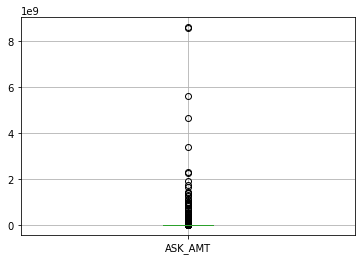

In [9]:
application_df.boxplot(column="ASK_AMT")

In [10]:
# determine number of upper bound outliers
upper_bound_outliers = application_df[application_df["ASK_AMT"] > 11855]
upper_bound_outliers.count()

APPLICATION_TYPE    8206
AFFILIATION         8206
CLASSIFICATION      8206
USE_CASE            8206
ORGANIZATION        8206
INCOME_AMT          8206
ASK_AMT             8206
IS_SUCCESSFUL       8206
dtype: int64

In [11]:
# determine number of lower bound outliers
lower_bound_outliers = application_df[application_df["ASK_AMT"] < 877]
lower_bound_outliers.count()

APPLICATION_TYPE    0
AFFILIATION         0
CLASSIFICATION      0
USE_CASE            0
ORGANIZATION        0
INCOME_AMT          0
ASK_AMT             0
IS_SUCCESSFUL       0
dtype: int64

In [12]:
# filter dataframe to exclude outliers
application_df = application_df[application_df["ASK_AMT"] < 11855]
len(application_df)

26093

In [13]:
# determine the number of unique values in each column
application_df.nunique()

APPLICATION_TYPE     12
AFFILIATION           6
CLASSIFICATION       65
USE_CASE              5
ORGANIZATION          4
INCOME_AMT            9
ASK_AMT             656
IS_SUCCESSFUL         2
dtype: int64

In [14]:
# look at APPLICATION_TYPE value counts for binning
application_counts = application_df.APPLICATION_TYPE.value_counts()
application_counts

T3     20086
T4      1331
T19      999
T5       894
T6       882
T8       669
T7       633
T10      508
T13       54
T9        18
T12       13
T2         6
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

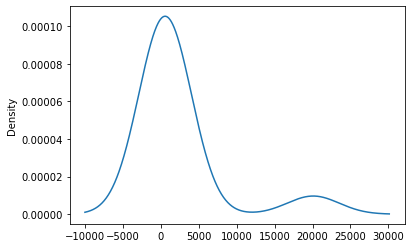

In [15]:
# visualize the value counts of APPLICATION_TYPE
application_counts.plot.density()

In [16]:
# eplace if counts are less than 200
replace_application = list(application_counts[application_counts <200].index) 

# replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       20086
T4        1331
T19        999
T5         894
T6         882
T8         669
T7         633
T10        508
Other       91
Name: APPLICATION_TYPE, dtype: int64

In [17]:
# look at CLASSIFICATION value counts for binning
classification_counts = application_df.CLASSIFICATION.value_counts()
classification_counts

C1000    12557
C2000     4693
C1200     3997
C2100     1623
C3000     1537
         ...  
C1732        1
C1728        1
C4120        1
C1245        1
C2150        1
Name: CLASSIFICATION, Length: 65, dtype: int64

<AxesSubplot:ylabel='Density'>

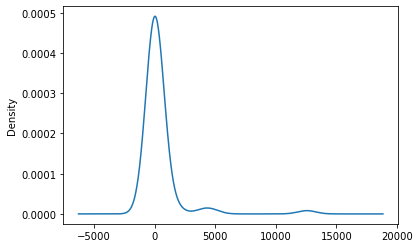

In [18]:
# visualize the value counts of CLASSIFICATION
classification_counts.plot.density()

In [19]:
# replace if counts are less than 1000
replace_class = list(classification_counts[classification_counts < 1000].index) 

# replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    12557
C2000     4693
C1200     3997
Other     1686
C2100     1623
C3000     1537
Name: CLASSIFICATION, dtype: int64

In [20]:
# Generate our categorical variable lists
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT']

In [21]:
# remove warning message
warnings.filterwarnings('ignore')

# create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# ddd the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# merge one-hot encoded features and drop the originals
new_application_df = application_df.merge(encode_df, left_index=True, right_index=True).drop([
    "APPLICATION_TYPE", "CLASSIFICATION", "AFFILIATION", "USE_CASE", "ORGANIZATION", "INCOME_AMT"], 1)
new_application_df.head()

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5000,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5000,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5000,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# split our preprocessed data into our features and target arrays
y = new_application_df["IS_SUCCESSFUL"].values
X = new_application_df.drop(["IS_SUCCESSFUL"],1).values

# split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1)

In [24]:
# create a StandardScaler instance
scaler = StandardScaler()

# fit the StandardScaler
X_scaler = scaler.fit(X_train)

# scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Deliverable 2: Compile, Train and Evaluate the Model

In [25]:
# define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 80
hidden_nodes_layer2 = 30
hidden_nodes_layer3 = 10

nn = tf.keras.models.Sequential()

# first hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,
                            input_dim=number_input_features,
                            activation="sigmoid"))

# second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, 
                            activation="sigmoid"))

# third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3,
                            activation="sigmoid"))

# output layer
nn.add(tf.keras.layers.Dense(units=1, activation="tanh"))

# check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3280      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 6,031
Trainable params: 6,031
Non-trainable params: 0
_________________________________________________________________


In [26]:
# compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period=5)

In [27]:
# train the model
fit_model = nn.fit(X_train, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6963 - accuracy: 0.5268
Epoch 2/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6923 - accuracy: 0.5272
Epoch 3/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6926 - accuracy: 0.5282
Epoch 4/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6924 - accuracy: 0.5287
Epoch 5/100
462/470 [============================>.] - ETA: 0s - loss: 0.6923 - accuracy: 0.5243
Epoch 5: saving model to checkpoints/weights_2.05.hdf5
470/470 [==============================] - 1s 3ms/step - loss: 0.6925 - accuracy: 0.5227
Epoch 6/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6926 - accuracy: 0.5246
Epoch 7/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6927 - accuracy: 0.5275
Epoch 8/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6921 - accuracy: 0.5304
Epoch 9/100
470/470 [==============================]

470/470 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5332
Epoch 65/100
456/470 [============================>.] - ETA: 0s - loss: 0.6914 - accuracy: 0.5340
Epoch 65: saving model to checkpoints/weights_2.65.hdf5
470/470 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5332
Epoch 66/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6917 - accuracy: 0.5316
Epoch 67/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.5298
Epoch 68/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5319
Epoch 69/100
470/470 [==============================] - 1s 2ms/step - loss: 0.6917 - accuracy: 0.5332
Epoch 70/100
453/470 [===========================>..] - ETA: 0s - loss: 0.6915 - accuracy: 0.5320
Epoch 70: saving model to checkpoints/weights_2.70.hdf5
470/470 [==============================] - 1s 2ms/step - loss: 0.6916 - accuracy: 0.5310
Epoch 71/100
470/

In [28]:
# evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

157/157 - 0s - loss: 0.6912 - accuracy: 0.5318 - 307ms/epoch - 2ms/step
Loss: 0.691187858581543, Accuracy: 0.5318299531936646


In [29]:
# export the model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization_2.h5")